# Script to predict the field of the offers by looking through the text.

Required libraries.

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#for word embedding
import gensim
from gensim.models import Word2Vec #Word2Vec is mostly used for huge datasets

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tboug\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\tboug\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tboug\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tboug\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


The txt_file file is a training file useful to develop the script (!!! We have to manually complete it !!!).

We open it and change the content into a Dataframe with the text and the corresponding class.

In [2]:
txt_file = 'Details.txt'

with open(txt_file, encoding = 'utf-8') as f:
    txt=f.read()
txt=txt.split(';;;')

txt=np.reshape(txt,(int(len(txt)/2),2))
df_txt=pd.DataFrame(txt,columns=['Text','Class'])
df_txt.head()

,Text,Class
0,- Nom et adresse officiels de l'organisme ache...,Assurance
1,\n- Nom et adresse officiels de l'organisme ac...,Management
2,\n- Nom et adresse officiels de l'organisme ac...,Restauration
3,\n- Nom et adresse officiels de l'organisme ac...,Construction
4,\n- Nom et adresse officiels de l'organisme ac...,Assurance


Display the different classes and their number of apparition.

Construction         5
Genie civil          4
Assurance            3
Energie              2
Achat                2
Developpement web    1
Restauration         1
Vente                1
Menuiserie           1
Location             1
Management           1
Chimie               1
Name: Class, dtype: int64


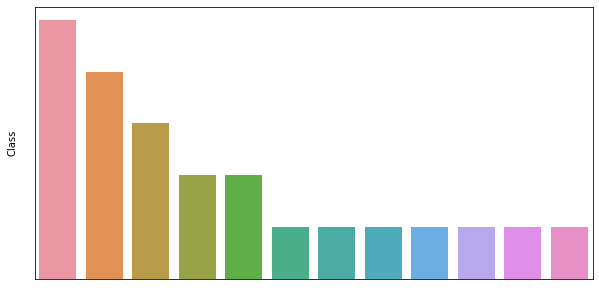

In [3]:
# CLASS DISTRIBUTION
#if dataset is balanced or not
fig,ax=plt.subplots(figsize=(10,5))
x=df_txt.Class.value_counts()
print(x)
sns.barplot(x.index,x,ax=ax)
ax.tick_params(colors='white')

Checking the missing values (there's none in the manually filled file).

In [4]:
#Missing values
df_txt.isna().sum()

Text     0
Class    0
dtype: int64

Check the mean number of words, character and unique word in the texts.

In [5]:
#1. WORD-COUNT
df_txt['word_count'] = df_txt['Text'].apply(lambda x: len(str(x).split()))
for i in df_txt.Class.value_counts().index:
    print(df_txt[df_txt.Class==i]['word_count'].mean())
    print(df_txt[df_txt.Class!=i]['word_count'].mean())

#2. CHARACTER-COUNT
df_txt['char_count'] = df_txt['Text'].apply(lambda x: len(str(x)))
for i in df_txt.Class.value_counts().index:
    print(df_txt[df_txt.Class==i]['char_count'].mean())
    print(df_txt[df_txt.Class!=i]['char_count'].mean())

#3. UNIQUE WORD-COUNT
df_txt['unique_word_count'] = df_txt['Text'].apply(lambda x: len(set(str(x).split())))
for i in df_txt.Class.value_counts().index:
    print(df_txt[df_txt.Class==i]['unique_word_count'].mean())
    print(df_txt[df_txt.Class!=i]['unique_word_count'].mean())

979.2
915.7222222222222
1234.0
865.421052631579
761.6666666666666
954.7
315.5
988.0
942.5
928.2857142857143
1762.0
891.6818181818181
1647.0
896.9090909090909
1142.0
919.8636363636364
377.0
954.6363636363636
502.0
948.9545454545455
602.0
944.4090909090909
714.0
939.3181818181819
6600.6
6379.944444444444
8767.0
5935.473684210527
5282.0
6599.8
2254.0
6825.428571428572
6593.0
6412.190476190476
12086.0
6170.727272727273
11060.0
6217.363636363636
7714.0
6369.454545454545
2592.0
6602.272727272727
3519.0
6560.136363636364
4345.0
6522.590909090909
4915.0
6496.681818181818
483.8
430.0
548.0
419.3157894736842
392.0
449.15
194.5
465.23809523809524
441.5
441.7142857142857
799.0
425.45454545454544
726.0
428.77272727272725
532.0
437.59090909090907
222.0
451.6818181818182
249.0
450.45454545454544
234.0
451.1363636363636
338.0
446.40909090909093


Plot of the number of text in function of the number of words for each class.

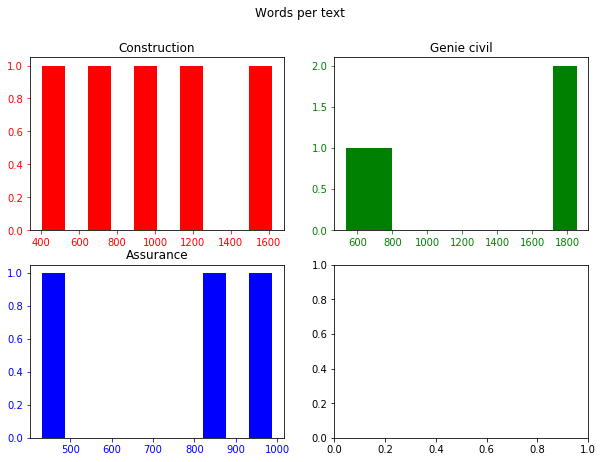

In [6]:
#Plotting word-count per tweet
fig,ax=plt.subplots(2,2,figsize=(10,7))

train_words=df_txt[df_txt['Class']==df_txt.Class.value_counts().index[0]]['word_count']
ax[0,0].hist(train_words,color='red')
ax[0,0].set_title(df_txt.Class.value_counts().index[0])
ax[0,0].tick_params(colors='red')

train_words=df_txt[df_txt['Class']==df_txt.Class.value_counts().index[1]]['word_count']
ax[0,1].hist(train_words,color='green')
ax[0,1].set_title(df_txt.Class.value_counts().index[1])
ax[0,1].tick_params(colors='green')

train_words=df_txt[df_txt['Class']==df_txt.Class.value_counts().index[2]]['word_count']
ax[1,0].hist(train_words,color='blue')
ax[1,0].set_title(df_txt.Class.value_counts().index[2])
ax[1,0].tick_params(colors='blue')

#train_words=df_txt[df_txt['Class']==df_txt.Class.value_counts().index[3]]['word_count']
#ax[1,1].hist(train_words,color='orange')
#ax[1,1].set_title(df_txt.Class.value_counts().index[3])
#ax[1,1].tick_params(colors='orange')

fig.suptitle('Words per text')
plt.show()

Cleaning of the text from unrequired symbols.

In [7]:
#1. Common text preprocessing
text = "   This is a message to be cleaned. It may involve some things like: <br>, ?, :, ''  adjacent spaces and tabs     .  "

#convert to lowercase and remove punctuations and characters and then strip
def preprocess(text):
    text = text.lower() #lowercase text
    text=text.strip()  #get rid of leading/trailing whitespace 
    text=re.compile('<.*?>').sub('', text) #Remove HTML tags/markups
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  #Replace punctuation with space. Careful since punctuation can sometime be useful
    text = re.sub('\s+', ' ', text)  #Remove extra space and tabs
    text = re.sub(r'\[[0-9]*\]',' ',text) #[0-9] matches any digit (0 to 10000...)
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) #matches any digit from 0 to 100000..., \D matches non-digits
    text = re.sub(r'\s+',' ',text) #\s matches any whitespace, \s+ matches multiple whitespace, \S matches non-whitespace 
    
    return text

text=preprocess(text)
print(text)  #text is a string

this is a message to be cleaned it may involve some things like adjacent spaces and tabs


Cleaning of the text from useless words.

In [8]:
#3. LEXICON-BASED TEXT PROCESSING EXAMPLES
 
#1. STOPWORD REMOVAL
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('french')]
    return ' '.join(a)

text=stopword(text)
print(text)

#2. STEMMING
 
# Initialize the stemmer
snow = SnowballStemmer('french')
def stemming(string):
    a=[snow.stem(i) for i in word_tokenize(string) ]
    return " ".join(a)
text=stemming(text)
print(text)

#3. LEMMATIZATION
# Initialize the lemmatizer
wl = WordNetLemmatizer()
 
# This is a helper function to map NTLK position tags
# Full list is available here: https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

text = lemmatizer(text)
print(text)

this is a message to be cleaned it may involve some things like adjacent spaces and tabs
this is a messag to be cleaned it may involv som thing lik adjacent spac and tab
this be a messag to be clean it may involv som thing lik adjacent spac and tab


Cleaning of all the texts with the previous function and dropping the counting columns (!!! try to include them in the predicting model !!!).

In [9]:
#FINAL PREPROCESSING
def finalpreprocess(string):
    return lemmatizer(stopword(preprocess(string)))

df_txt['clean_text'] = df_txt['Text'].apply(lambda x: finalpreprocess(x))
df_txt=df_txt.drop(columns=['word_count','char_count','unique_word_count'])
df_txt.head()

,Text,Class,clean_text
0,- Nom et adresse officiels de l'organisme ache...,Assurance,nom adresse officiels organisme acheteur mairi...
1,\n- Nom et adresse officiels de l'organisme ac...,Management,nom adresse officiels organisme acheteur maiso...
2,\n- Nom et adresse officiels de l'organisme ac...,Restauration,nom adresse officiels organisme acheteur cnrs ...
3,\n- Nom et adresse officiels de l'organisme ac...,Construction,nom adresse officiels organisme acheteur oph h...
4,\n- Nom et adresse officiels de l'organisme ac...,Assurance,nom adresse officiels organisme acheteur ville...


Word2vec model creation.

In [10]:
# create Word2vec model
#here words_f should be a list containing words from each document. say 1st row of the list is words from the 1st document/sentence
#length of words_f is number of documents/sentences in your dataset
df_txt['clean_text_tok']=[nltk.word_tokenize(i) for i in df_txt['clean_text']] #convert preprocessed sentence to tokenized sentence
model = Word2Vec(df_txt['clean_text_tok'],min_count=1)  #min_count=1 means word should be present at least across all documents,
#if min_count=2 means if the word is present less than 2 times across all the documents then we shouldn't consider it


w2v = dict(zip(model.wv.index2word, model.wv.syn0))  #combination of word and its vector

#for converting sentence to vectors/numbers from word vectors result by Word2Vec
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(next(iter(word2vec.values())))

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

D:\Python\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  if __name__ == '__main__':


# Application of the model on the dataset.

In [11]:
#SPLITTING THE TRAINING DATASET INTO TRAINING AND VALIDATION
 
# Input: "reviewText", "rating" and "time"
# Target: "log_votes"
X_train, X_val, y_train, y_val = train_test_split(df_txt["clean_text"],
                                                  df_txt["Class"],
                                                  test_size=0.33,
                                                  random_state = 711047,
                                                  shuffle=True)
X_train_tok= [nltk.word_tokenize(i) for i in X_train]  #for word2vec
X_val_tok= [nltk.word_tokenize(i) for i in X_val]      #for word2vec

#TF-IDF
# Convert x_train to vector since model can only run on numbers and not words- Fit and transform
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) #tfidf runs on non-tokenized sentences unlike word2vec
# Only transform x_test (not fit and transform)
X_val_vectors_tfidf = tfidf_vectorizer.transform(X_val) #Don't fit() your TfidfVectorizer to your test data: it will 
#change the word-indexes & weights to match test data. Rather, fit on the training data, then use the same train-data-
#fit model on the test data, to reflect the fact you're analyzing the test data only based on what was learned without 
#it, and the have compatible


#Word2vec
# Fit and transform
modelw = MeanEmbeddingVectorizer(w2v)
X_train_vectors_w2v = modelw.transform(X_train_tok)
X_val_vectors_w2v = modelw.transform(X_val_tok)

Results.

In [12]:
#FITTING THE CLASSIFICATION MODEL using Logistic Regression(tf-idf)

lr_tfidf=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_tfidf.fit(X_train_vectors_tfidf, y_train)  #model

#Predict y value for test dataset
y_predict = lr_tfidf.predict(X_val_vectors_tfidf)
y_prob = lr_tfidf.predict_proba(X_val_vectors_tfidf)[:,1]
 

print(classification_report(y_val,y_predict))
print('Confusion Matrix:',confusion_matrix(y_val, y_predict))

              precision    recall  f1-score   support

       Achat       0.00      0.00      0.00         1
   Assurance       0.00      0.00      0.00         2
      Chimie       0.00      0.00      0.00         1
Construction       0.50      1.00      0.67         1
     Energie       0.00      0.00      0.00         1
 Genie civil       0.17      1.00      0.29         1
Restauration       0.00      0.00      0.00         1

    accuracy                           0.25         8
   macro avg       0.10      0.29      0.14         8
weighted avg       0.08      0.25      0.12         8

Confusion Matrix: [[0 0 0 0 0 1 0]
 [0 0 0 1 0 1 0]
 [0 0 0 0 0 1 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 1 0]]


D:\Python\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
D:\Python\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
